In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pywt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN


In [18]:
# Load dataset
df = pd.read_csv(r"C:\Users\Refurbstock\OneDrive\Desktop\iot_telemetry_data.csv")
df.head()


,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000


In [19]:

# Convert timestamp
df["timestamp"] = pd.to_datetime(df["ts"], unit="s")

# Use ONE device (important)
df = df[df["device"] == df["device"].unique()[0]]
df = df.sort_values("timestamp").reset_index(drop=True)

# Select environmental sensors
sensor_cols = ["temp", "humidity", "co", "lpg", "smoke"]

# Scale sensor values
scaler = StandardScaler()
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])


In [20]:
# STEP 2 — Create sliding windows

# Dual AEs need time windows, not single points.
WINDOW = 128
STEP = 64

X = df[sensor_cols].values
windows = []

for i in range(0, len(X) - WINDOW, STEP):
    windows.append(X[i:i+WINDOW])

windows = np.array(windows)
print("Windows shape:", windows.shape)


Windows shape: (2927, 128, 5)


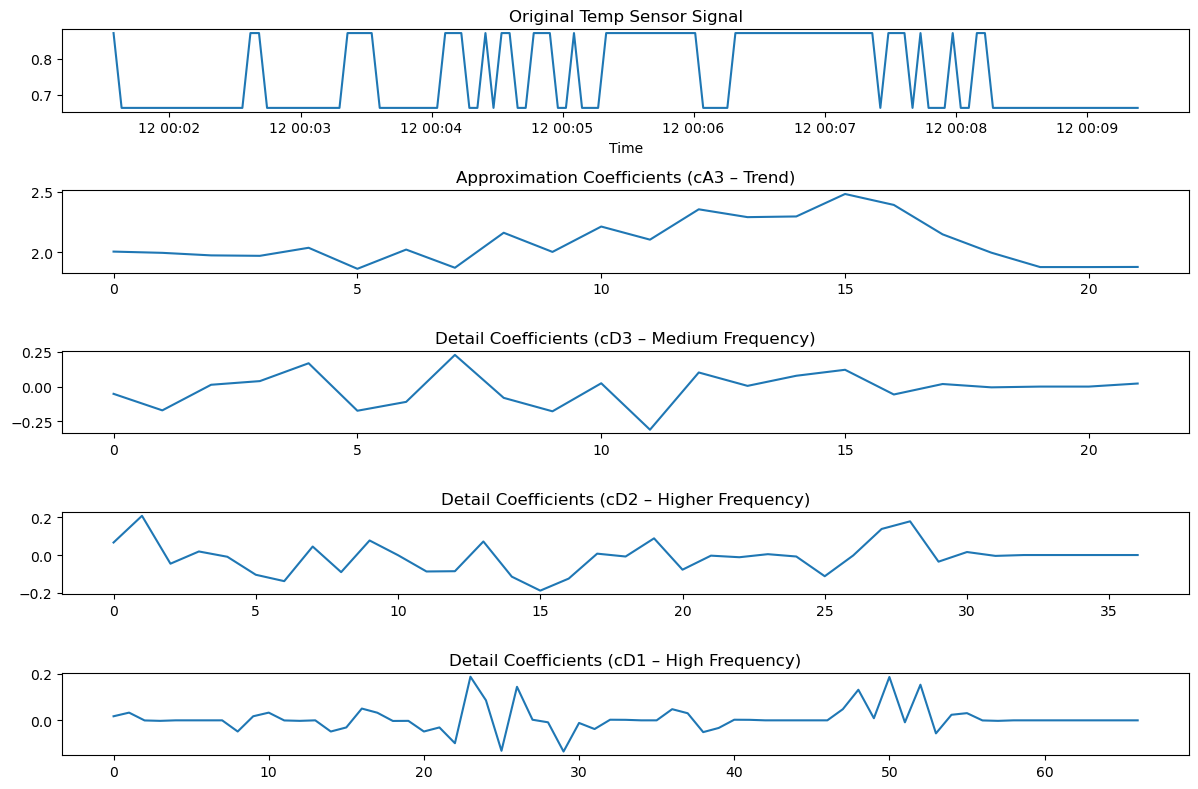

In [21]:
import matplotlib.pyplot as plt
import pywt
import numpy as np

# ---- SELECT WINDOW & SENSOR ----
window_idx = 0                     # any window index
sensor_name = "temp"               # choose IoT sensor
sensor_idx = sensor_cols.index(sensor_name)

# Extract signal from sliding windows
signal = windows[window_idx, :, sensor_idx]

# ---- WAVELET DECOMPOSITION ----
coeffs = pywt.wavedec(signal, 'db4', level=3)
cA3, cD3, cD2, cD1 = coeffs

# ---- TIME AXIS (for better visualization) ----
start = window_idx * STEP
end = start + WINDOW
time_axis = df["timestamp"].iloc[start:end]

# ---- PLOTTING ----
plt.figure(figsize=(12, 8))

plt.subplot(5, 1, 1)
plt.plot(time_axis, signal)
plt.title(f"Original {sensor_name.capitalize()} Sensor Signal")
plt.xlabel("Time")

plt.subplot(5, 1, 2)
plt.plot(cA3)
plt.title("Approximation Coefficients (cA3 – Trend)")

plt.subplot(5, 1, 3)
plt.plot(cD3)
plt.title("Detail Coefficients (cD3 – Medium Frequency)")

plt.subplot(5, 1, 4)
plt.plot(cD2)
plt.title("Detail Coefficients (cD2 – Higher Frequency)")

plt.subplot(5, 1, 5)
plt.plot(cD1)
plt.title("Detail Coefficients (cD1 – High Frequency)")

plt.tight_layout()
plt.show()


In [22]:
def extract_wavelet_features(window):
    coeffs = []
    for channel in window.T:
        c = pywt.wavedec(channel, 'db4', level=3)
        coeffs.append(np.concatenate(c))
    return np.concatenate(coeffs)

wavelet_features = np.array(
    [extract_wavelet_features(w) for w in windows]
)

print("Wavelet features:", wavelet_features.shape)


Wavelet features: (2927, 740)


In [23]:
# Statistical features:
def extract_stats(window):
    feats = []
    for channel in window.T:
        feats += [
            np.mean(channel),
            np.std(channel),
            np.min(channel),
            np.max(channel),
            np.median(channel),
            np.percentile(channel, 25),
            np.percentile(channel, 75),
        ]
    return np.array(feats)

stat_features = np.array(
    [extract_stats(w) for w in windows]
)

print("Stat features:", stat_features.shape)


Stat features: (2927, 35)


In [24]:
# statistics for the first window
one_window_stats = extract_stats(windows[0])

print(one_window_stats)
print("Shape:", one_window_stats.shape)


[ 0.75164479  0.10248139  0.66410087  0.87161239  0.66410087  0.66410087
  0.87161239  0.08726118  0.05793738 -0.21921335  0.20430881  0.09842827
  0.045488    0.09842827 -1.043127    0.04002495 -1.15654711 -0.93094498
 -1.04363647 -1.06864602 -1.0166013  -1.05432663  0.04162575 -1.17245177
 -0.93784811 -1.05483057 -1.08084778 -1.02672882 -1.05236361  0.04133864
 -1.16964408 -0.93665482 -1.05286866 -1.07870511 -1.02495814]
Shape: (35,)


In [25]:
import pandas as pd

stat_names = [
    "Mean", "Std", "Min", "Max",
    "Median", "P25", "P75"
]

num_sensors = windows[0].shape[1]

# Reshape (35,) → (num_sensors, 7)
stats_reshaped = one_window_stats.reshape(num_sensors, len(stat_names))

df_stats = pd.DataFrame(
    stats_reshaped,
    columns=stat_names,
    index=[f"Sensor_{i+1}" for i in range(num_sensors)]
)

print(df_stats)


              Mean       Std       Min       Max    Median       P25       P75
Sensor_1  0.751645  0.102481  0.664101  0.871612  0.664101  0.664101  0.871612
Sensor_2  0.087261  0.057937 -0.219213  0.204309  0.098428  0.045488  0.098428
Sensor_3 -1.043127  0.040025 -1.156547 -0.930945 -1.043636 -1.068646 -1.016601
Sensor_4 -1.054327  0.041626 -1.172452 -0.937848 -1.054831 -1.080848 -1.026729
Sensor_5 -1.052364  0.041339 -1.169644 -0.936655 -1.052869 -1.078705 -1.024958


In [26]:
# STEP 4 — Build the Dual Autoencoder

# We create:

# Wavelet Autoencoder → input = flattened wavelet features

# Feature Autoencoder → input = statistical features


class AE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z


In [27]:

# Initialize autoencoders
waveX = torch.tensor(wavelet_features, dtype=torch.float32)
featX = torch.tensor(stat_features, dtype=torch.float32)

waveAE = AE(waveX.shape[1], latent_dim=64)
featAE = AE(featX.shape[1], latent_dim=16)


# STEP 5 — Train both AEs
# Convert features to tensors
loader = DataLoader(
    TensorDataset(waveX, featX),
    batch_size=128,
    shuffle=True
)
# Optimizer and loss
optimizer = torch.optim.Adam(
    list(waveAE.parameters()) + list(featAE.parameters()),
    lr=1e-3
)

loss_fn = nn.MSELoss()
loss_history = []

for epoch in range(20):
    total_loss = 0
    for w, f in loader:
        w_hat, _ = waveAE(w)
        f_hat, _ = featAE(f)

        loss = loss_fn(w_hat, w) + loss_fn(f_hat, f)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")


Epoch 0: Loss = 1.0776
Epoch 1: Loss = 0.1910
Epoch 2: Loss = 0.0816
Epoch 3: Loss = 0.0603
Epoch 4: Loss = 0.0404
Epoch 5: Loss = 0.0319
Epoch 6: Loss = 0.0281
Epoch 7: Loss = 0.0249
Epoch 8: Loss = 0.0207
Epoch 9: Loss = 0.0184
Epoch 10: Loss = 0.0175
Epoch 11: Loss = 0.0169
Epoch 12: Loss = 0.0164
Epoch 13: Loss = 0.0156
Epoch 14: Loss = 0.0145
Epoch 15: Loss = 0.0134
Epoch 16: Loss = 0.0124
Epoch 17: Loss = 0.0116
Epoch 18: Loss = 0.0109
Epoch 19: Loss = 0.0104


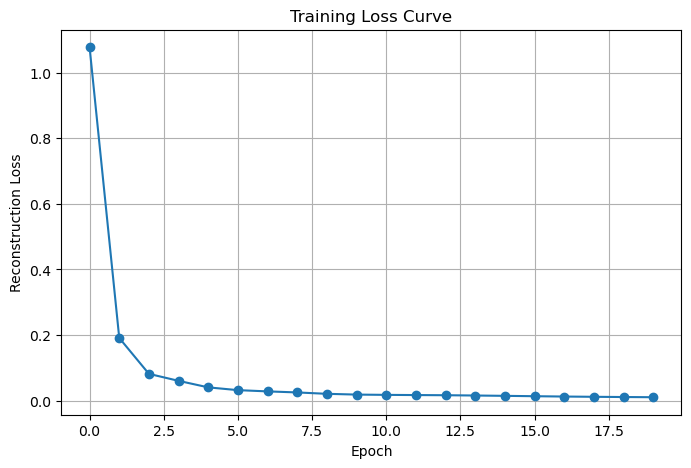

In [28]:
plt.figure(figsize=(8,5))
plt.plot(loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()


In [29]:
wave_rec, _ = waveAE(waveX)
feat_rec, _ = featAE(featX)

wave_err = ((wave_rec - waveX)**2).mean(dim=1).detach().numpy()
feat_err = ((feat_rec - featX)**2).mean(dim=1).detach().numpy()

combined_err = np.column_stack([wave_err, feat_err])


In [30]:
scaled_err = StandardScaler().fit_transform(combined_err)

db = DBSCAN(eps=0.8, min_samples=10).fit(scaled_err)
labels = db.labels_

print("Detected anomalous windows:", np.sum(labels == -1))


Detected anomalous windows: 8


In [31]:
from sklearn.metrics import silhouette_score
import numpy as np

# Use the same feature space as DBSCAN
X = scaled_err

# Remove anomalies (DBSCAN label = -1)
mask = labels != -1
X_valid = X[mask]
labels_valid = labels[mask]

# Silhouette score requires at least 2 clusters
if len(np.unique(labels_valid)) > 1:
    sil_score = silhouette_score(X_valid, labels_valid)
    print("Silhouette Score:", sil_score)
else:
    print("Silhouette Score not defined (only one normal cluster)")


Silhouette Score not defined (only one normal cluster)


In [32]:
anomaly_indices = np.where(labels == -1)[0]

anomaly_times = []
for i in anomaly_indices:
    start_row = min(i * STEP, len(df) - 1)
    anomaly_times.append(df["timestamp"].iloc[start_row])

print("Anomaly start times:")
for t in anomaly_times:
    print(t)


Anomaly start times:
2020-07-16 07:05:36.776177883
2020-07-16 07:09:32.570710897
2020-07-16 07:13:28.274747610
2020-07-18 01:46:52.641232729
2020-07-18 01:50:48.773579836
2020-07-18 13:27:07.081360579
2020-07-18 13:31:03.197905302
2020-07-18 13:46:46.215450287


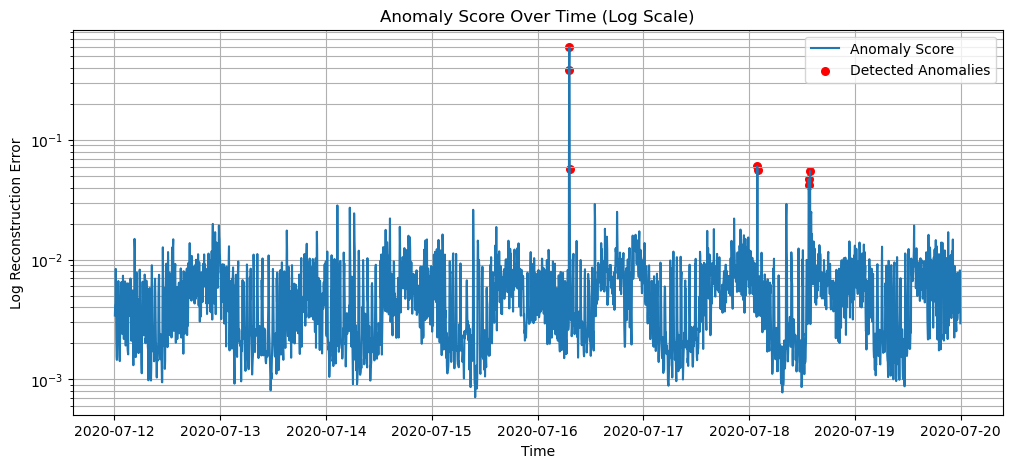

In [33]:
# Compute a single anomaly score (same one used for DBSCAN)
final_score = 0.7 * wave_err + 0.3 * feat_err

# Map window index to timestamp (window center is better)
window_times = []
for i in range(len(final_score)):
    center_row = min(i * STEP + WINDOW // 2, len(df) - 1)
    window_times.append(df["timestamp"].iloc[center_row])

window_times = np.array(window_times)

# Plot
plt.figure(figsize=(12,5))
plt.semilogy(window_times, final_score, label="Anomaly Score")
plt.scatter(
    window_times[labels == -1],
    final_score[labels == -1],
    color="red",
    s=30,
    label="Detected Anomalies"
)
plt.xlabel("Time")
plt.ylabel("Log Reconstruction Error")
plt.title("Anomaly Score Over Time (Log Scale)")
plt.legend()
plt.grid(True, which="both")
plt.show()



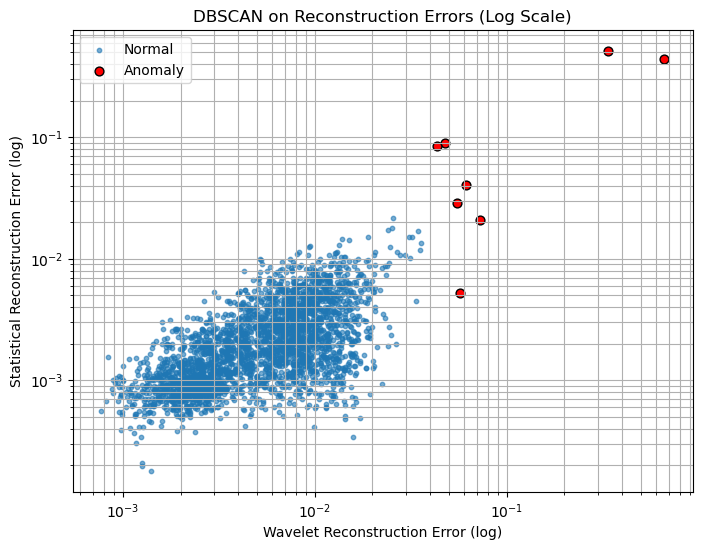

In [34]:
plt.figure(figsize=(8,6))

plt.scatter(
    combined_err[labels != -1, 0],
    combined_err[labels != -1, 1],
    s=10,
    alpha=0.6,
    label="Normal"
)

plt.scatter(
    combined_err[labels == -1, 0],
    combined_err[labels == -1, 1],
    color="red",
    edgecolors="k",
    s=40,
    label="Anomaly"
)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Wavelet Reconstruction Error (log)")
plt.ylabel("Statistical Reconstruction Error (log)")
plt.title("DBSCAN on Reconstruction Errors (Log Scale)")
plt.legend()
plt.grid(True, which="both")
plt.show()
